In [36]:
import matplotlib.pyplot as plt
from mxnet import autograd, nd, context, init, gluon
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
import numpy as np
from IPython import display

In [37]:
class Animator(object):
    def __init__(self, xlabel=None, ylabel=None, legend=[], xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(3.5, 2.5)):
        """Incrementally plot multiple lines."""
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1: self.axes = [self.axes,]
        # use a lambda to capture arguments
        self.config_axes = lambda : Animator.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    @staticmethod
    def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
      """A utility function to set matplotlib axes"""
      axes.set_xlabel(xlabel)
      axes.set_ylabel(ylabel)
      axes.set_xscale(xscale)
      axes.set_yscale(yscale)
      axes.set_xlim(xlim)
      axes.set_ylim(ylim)
      if legend: axes.legend(legend)
      axes.grid()
    
    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"): y = [y]
        n = len(y)
        if not hasattr(x, "__len__"): x = [x] * n
        if not self.X: self.X = [[] for _ in range(n)]
        if not self.Y: self.Y = [[] for _ in range(n)]
        if not self.fmts: self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [48]:
def eval_acc(net, data_iter, ctx):
    acc = 0
    size = 0
    for X, y in data_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        result = net(X).softmax(axis=1).argmax(axis=1)
        acc += (result==y.astype('float32')).sum().asscalar()
        size += len(y)
    return acc/size

In [2]:
def get_dataloader(batch_size, resize=None, shuffle=True):
    transforms_list = []
    if resize is not None:
        transforms_list.append(transforms.Resize(resize))
    transforms_list.append(transforms.ToTensor())
    transformer = transforms.Compose(transforms_list)
    train = gluon.data.vision.datasets.FashionMNIST(train=True)
    train = train.transform_first(transformer)
    train_iter = gluon.data.DataLoader(train, batch_size, shuffle, num_workers=4)
    test = gluon.data.vision.datasets.FashionMNIST(train=False)
    test = test.transform_first(transformer)
    test_iter = gluon.data.DataLoader(test, batch_size, shuffle=False, num_workers=4)
    return train_iter, test_iter, train, test

In [3]:
def show_images(X, nrows, ncols):
    _, axes = plt.subplots(nrows, ncols)
    axes = axes.flatten()
    for img, ax in zip(X, axes):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    return axes

In [4]:
class InceptionBlock(nn.Block):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(InceptionBlock, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2D(c1, kernel_size=1, activation='relu')
        
        self.p2_1 = nn.Conv2D(c2[0], kernel_size=1, activation='relu')
        self.p2_2 = nn.Conv2D(c2[1], kernel_size=3, padding=1, activation='relu')
        
        self.p3_1 = nn.Conv2D(c3[0], kernel_size=1, activation='relu')
        self.p3_2 = nn.Conv2D(c3[1], kernel_size=5, padding=2, activation='relu')
        
        self.p4_1 = nn.MaxPool2D(pool_size=3, strides=1, padding=1)
        self.p4_2 = nn.Conv2D(c4, kernel_size=1, activation='relu')
        
    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(p1))
        p3 = self.p3_2(self.p3_1(p2))
        p4 = self.p4_2(self.p4_1(p3))
        return nd.concat(p1, p2, p3, p4, dim=1)

In [14]:
class Inception(nn.Block):
    def __init__(self, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.network = self.get_network()
    def __getitem__(self, key):
        return self.network[key]
    def __len__(self):
        return len(self.network)
    def get_network(self):
        blk = nn.Sequential()
        
        b1 = nn.Sequential()
        b1.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3, activation='relu'))
        b1.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
        
        b2 = nn.Sequential()
        b2.add(nn.Conv2D(64, kernel_size=1, activation='relu'))
        b2.add(nn.Conv2D(192, kernel_size=3, padding=1, activation='relu'))
        b2.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
        
        b3 = nn.Sequential()
        b3.add(InceptionBlock(64, (96, 128), (16, 32), 32))
        b3.add(InceptionBlock(128, (128, 192), (32, 96), 64))
        b3.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
        
        b4 = nn.Sequential()
        b4.add(InceptionBlock(192, (96, 208), (16, 48), 64))
        b4.add(InceptionBlock(160, (112, 224), (24, 64), 64))
        b4.add(InceptionBlock(128, (128, 256), (24, 64), 64))
        b4.add(InceptionBlock(112, (144, 288), (32, 64), 64))
        b4.add(InceptionBlock(256, (160, 320), (32, 128), 128))
        b4.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
        
        b5 = nn.Sequential()
        b5.add(InceptionBlock(256, (160, 320), (32, 128), 128))
        b5.add(InceptionBlock(384, (192, 384), (48, 128), 128))
        b5.add(nn.GlobalAvgPool2D())
        
        blk.add(b1, b2, b3, b4, b5, nn.Dense(10))
        
        return blk
    def forward(self, x):
        out = self.network(x)
        return out

In [41]:
batch_size = 4
train_iter, test_iter, train, test = get_dataloader(batch_size, resize=None)

(4, 1, 28, 28)
(4,)


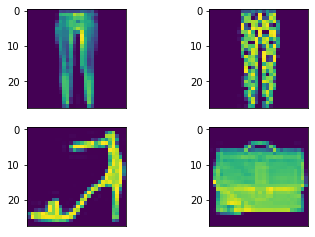

In [42]:
for X, y in train_iter:
    print(X.shape)
    print(y.shape)
    show_images(X.squeeze(axis=1).asnumpy(), 2, 2)
    break

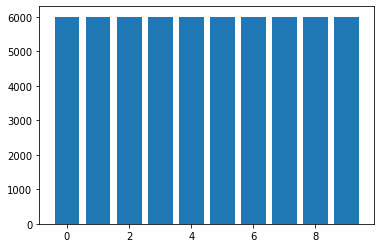

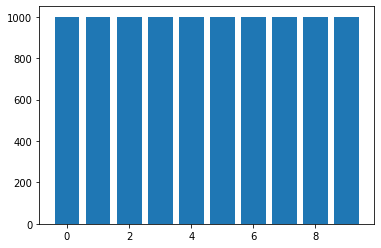

In [43]:
trainX, trainY = train[:]
classes, class_dist = np.unique(trainY, return_counts=True)
_, ax = plt.subplots()
ax.bar(classes, class_dist)
plt.show()
testX, testY = test[:]
classes, class_dist = np.unique(testY, return_counts=True)
_, ax = plt.subplots()
ax.bar(classes, class_dist)
plt.show()

In [44]:
ctx = context.gpu()
net = Inception()
net.initialize(init=init.Xavier(), ctx=ctx)

testX = nd.random.normal(shape=(1, 1, 96, 96), ctx=ctx)
for i in range(len(net)):
    layer = net[i]
    testX = layer(testX)
    print(layer.name, testX.shape)

sequential63 (1, 64, 24, 24)
sequential64 (1, 192, 12, 12)
sequential65 (1, 480, 6, 6)
sequential66 (1, 832, 3, 3)
sequential67 (1, 1024, 1, 1)
dense9 (1, 10)


In [45]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()
print(loss(testX, nd.array([1]).as_in_context(ctx)).sum())


[2.3023837]
<NDArray 1 @gpu(0)>


In [46]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate':3e-5})

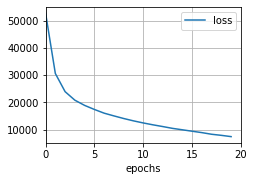

In [47]:
epochs = 20
animator = Animator(xlabel='epochs', xlim=[0, epochs], legend=['loss'])

for epoch in range(epochs):
    epoch_loss = 0
    for X, y in train_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
        epoch_loss += l.sum().asscalar()
    animator.add(epoch, (epoch_loss))

In [51]:
acc = eval_acc(net, test_iter, ctx)

In [52]:
print(acc)

0.9131
